In [1]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img
from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
import cvxpy as cp
from sklearn.model_selection import KFold
from itertools import product
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA
import scipy.sparse as sp

Loading Datasets and Masks

In [2]:
ses = 1
sub = '04'
run = 2

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz')

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()
bold_data = bold_data.astype(np.float16)

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
back_mask = nib.load(mask_path)
back_mask = back_mask.get_fdata()
back_mask = back_mask.astype(np.float16)

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
csf_mask = nib.load(mask_path)
csf_mask = csf_mask.get_fdata()
csf_mask = csf_mask.astype(np.float16)

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_1.nii.gz'
white_mask = nib.load(mask_path)
white_mask = white_mask.get_fdata()
white_mask = white_mask.astype(np.float16)

print(anat_img.shape)
# print(bold_data.shape)
# print(back_mask.shape)
# print(csf_mask.shape)

(180, 256, 170)


Apply Masks on Bold Dataset

In [3]:
back_mask_data = back_mask > 0
csf_mask_data = csf_mask > 0
white_mask_data = white_mask > 0.5
mask = np.logical_and(back_mask_data, ~csf_mask_data)
mask &= ~white_mask_data
nonzero_mask = np.where(mask)
masked_bold = bold_data[nonzero_mask]

print(f"number of selected voxels after masking: {masked_bold.shape[0]/math.prod(bold_data.shape[:3])*100:.2f}%")
print('bold_data masked shape:', masked_bold.shape)

number of selected voxels after masking: 7.91%
bold_data masked shape: (619385, 850)


Load Beta values, Mask it, Find threshold to determine and delete outlier voxels

In [4]:
glm_dict = np.load(f'TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]

mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)
white_mask_flat = white_mask_data[nonzero_mask]
if run == 1:
    beta = beta_run1[~white_mask_flat]
else:
    beta = beta_run2[~white_mask_flat]
print("Beta Range:[", np.nanmin(beta), np.nanmax(beta), "], Mean: ", np.nanmean(beta))

lower_thr, upper_thr = np.nanpercentile(beta, [1, 99])
print(f'low_thr: {lower_thr:.2f}, high_thr: {upper_thr:.2f}') #low_thr: -4.64, high_thr: 4.60
beta_extreme_mask = np.logical_or(beta < lower_thr, beta > upper_thr)
voxels_with_extreme_beta = np.any(beta_extreme_mask, axis=1)

print(f"percentage of voxels with extreme beta values: {np.sum(voxels_with_extreme_beta)/beta.shape[0]*100:.2f}%")

mask = np.logical_and(back_mask_data, ~csf_mask_data)
mask &= ~white_mask_data
nonzero_mask = np.where(mask)

clean_beta = beta[~voxels_with_extreme_beta]
print('clean_beta shape:', clean_beta.shape)

Beta Range:[ -3021.6572 2139.0798 ], Mean:  0.011265066
low_thr: -4.74, high_thr: 4.64
percentage of voxels with extreme beta values: 9.41%
clean_beta shape: (561079, 90)


Plot outlier voxel on the brain

In [5]:
extreme_volume = np.zeros(bold_img.shape[:3], dtype=np.float32)
extreme_volume[nonzero_mask] = voxels_with_extreme_beta.astype(np.float32)
extreme_img = nib.Nifti1Image(extreme_volume, bold_img.affine, bold_img.header)
extreme_img = resample_to_img(extreme_img, anat_img, interpolation='nearest')
view = plotting.view_img(
    extreme_img,
    bg_img=anat_img,
    cmap='autumn',
    symmetric_cmap=False,
    threshold=0.5,
    vmax=1,
    opacity=0.9,
    title='Voxels with Extreme Betas'
)
view
view.save_as_html(file_name=f'extreme_beta_voxels_sub{sub}_ses{ses}_run{run}.html')

/tmp/ipykernel_1972112/2888343218.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  extreme_img = resample_to_img(extreme_img, anat_img, interpolation='nearest')
/tmp/ipykernel_1972112/2888343218.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  extreme_img = resample_to_img(extreme_img, anat_img, interpolation='nearest')
/home/zkavian/Thesis_code_Glm_Opt/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_1972112/2888343218.py:5: UserWarning: Resampling binary images with continuous or linear interpolation. This might l

Histogram of all Beta values & outlier beta

(1114872,)


/tmp/ipykernel_1972112/638068488.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Histogram of outlier Beta values')

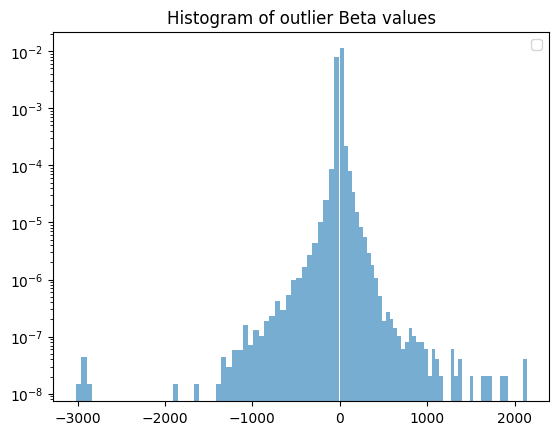

In [6]:
lower_thr, upper_thr = np.nanpercentile(beta, [1, 99])
m = (beta < lower_thr) | (beta > upper_thr)
outlier_vals = beta[m].ravel()
print(outlier_vals.shape)

neg_edges = np.linspace(np.nanmin(outlier_vals), lower_thr, 50, endpoint=True)
pos_edges = np.linspace(upper_thr, np.nanmax(outlier_vals), 50, endpoint=True)
edges = np.r_[neg_edges, pos_edges]  # note: there is a gap between lower_thr and upper_thr

plt.figure()
plt.hist(outlier_vals, bins=edges, density=True, alpha=0.6)
# plt.axvspan(lower_thr, upper_thr, alpha=0.15, label='excluded band')
plt.yscale('log')
plt.legend()
plt.title('Histogram of outlier Beta values')

/tmp/ipykernel_1972112/469673788.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Histogram of all Beta values')

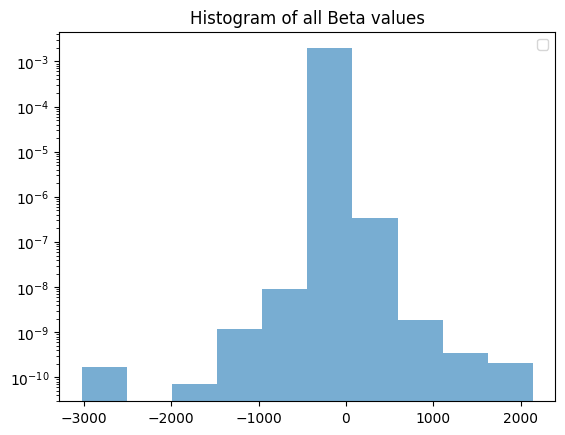

In [7]:
plt.figure()
plt.hist(beta.ravel(), density=True, alpha=0.6)
# plt.axvspan(lower_thr, upper_thr, alpha=0.15, label='excluded band')
plt.yscale('log')
plt.legend()
plt.title('Histogram of all Beta values')

In [7]:
# outlier_beta = beta[voxels_with_extreme_beta]
# beta_flat = outlier_beta.flatten()
# # finite_beta = beta_flat[np.isfinite(beta_flat)]
# finite_beta = beta[voxels_with_extreme_beta][
#     beta_extreme_mask[voxels_with_extreme_beta]
# ].ravel()

# n_bins = 30
# gamma = 5  # increase to allocate wider bins where beta is dense
# base = np.linspace(0.0, 1.0, n_bins + 1)
# tail_weighted = np.where(base <= 0.5, 0.5 * (2 * base) ** gamma, 1.0 - 0.5 * (2 * (1.0 - base)) ** gamma,)

# bin_edges = np.unique(np.quantile(finite_beta, tail_weighted))

# counts, edges = np.histogram(finite_beta, bins=bin_edges)
# widths = np.diff(edges)
# density = counts / widths
# positive_density = np.where(density > 0, density, np.nextafter(0, 1))

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(edges[:-1], positive_density, width=widths, align='edge', color='lightblue', edgecolor='blue', alpha=0.5)
# ax.set_xlabel('Beta')
# ax.set_ylabel('Count per beta unit')
# ax.set_title('outlier Beta Histogram')
# ax.set_yscale('log')
# ax.set_ylim(positive_density.min() * 0.9, positive_density.max() * 1.1)
# fig.tight_layout()
# plt.show()

Apply t-test and FDR, detect & remove non-active voxels

In [8]:
# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# reject non-active voxels
clean_active_beta = clean_beta[reject]
print(f"{clean_active_beta.shape[0]/clean_beta.shape[0]*100:.2f}% of voxels are active at FDR q<{alpha}")
clean_active_beta.shape

/home/zkavian/Thesis_code_Glm_Opt/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:634: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)
/tmp/ipykernel_1972112/2475598475.py:2: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')


50.29% of voxels are active at FDR q<0.05


(282162, 90)

Create 3-D beta dataset to use it for filtering

In [9]:
# transfer back beta value on the volume
clean_mask = ~np.asarray(voxels_with_extreme_beta, dtype=bool)
clean_indices = np.nonzero(clean_mask)[0]
active_indices = clean_indices[np.asarray(reject, dtype=bool)]

spatial_shape = bold_img.shape[:3]
n_trials = clean_active_beta.shape[1]
beta_volume = np.full(spatial_shape + (n_trials,), np.nan, dtype=np.float32)

coords = tuple(axis[active_indices] for axis in nonzero_mask)
beta_volume[coords[0], coords[1], coords[2], :] = clean_active_beta.astype(np.float32)

Map mean beta for active voxels back into anatomical space

In [11]:

clean_mask = ~np.asarray(voxels_with_extreme_beta, dtype=bool)
clean_indices = np.flatnonzero(clean_mask)
active_mask = np.asarray(reject, dtype=bool)
active_indices = clean_indices[active_mask]


active_voxel_coords = tuple(idx[active_indices] for idx in nonzero_mask)

mean_active_beta = np.nanmean(clean_active_beta, axis=1).astype(np.float32)
mean_beta_volume = np.full(bold_img.shape[:3], np.nan, dtype=np.float32)
mean_beta_volume[active_voxel_coords] = mean_active_beta

mean_beta_img = nib.Nifti1Image(mean_beta_volume, bold_img.affine, bold_img.header)
mean_beta_img = resample_to_img(mean_beta_img, anat_img, interpolation='linear')

finite_vals = np.isfinite(mean_active_beta)
if np.any(finite_vals):
    vmax = np.nanpercentile(mean_active_beta[finite_vals], 99)
    vmin = np.nanpercentile(mean_active_beta[finite_vals], 1)
else:
    vmax = vmin = 0.0

active_beta_view = plotting.view_img(
    mean_beta_img,
    bg_img=anat_img,
    cmap='seismic',
    symmetric_cmap=False,
    threshold=1e-6,
    vmax=vmax,
    vmin=vmin,
    colorbar=True,
    title='Mean beta for active voxels'
)
active_beta_view
active_beta_view.save_as_html(file_name=f'active_beta_map_sub{sub}_ses{ses}_run{run}.html')

/tmp/ipykernel_1972112/272021680.py:14: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  mean_beta_img = resample_to_img(mean_beta_img, anat_img, interpolation='linear')
/tmp/ipykernel_1972112/272021680.py:14: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_beta_img = resample_to_img(mean_beta_img, anat_img, interpolation='linear')
/tmp/ipykernel_1972112/272021680.py:23: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  active_beta_view = plotting.view_img(
/home/zkavian/Thesis_code_Glm_Opt/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kt

Apply Hampel Filter to have smooth beta value (remove voxels that have 0-2 neighbour, smooth beta for voxles with more than 2 neighbour)

In [ ]:
def hampel_filter_image(image, window_size, threshold_factor, return_stats=False):
    if window_size % 2 == 0:
        raise ValueError("window_size must be odd")

    filtered = image.astype(float).copy()
    footprint = np.ones((window_size,) * 3, dtype=bool)

    insufficient_counts = []
    corrected_indices_parts = []

    for t in range(image.shape[3]):
        vol = image[..., t]
        med = ndimage.generic_filter(vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
        mad = ndimage.generic_filter(np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
        counts = ndimage.generic_filter(np.isfinite(vol).astype(np.float32), np.sum, footprint=footprint, mode='constant', cval=0)

        scaled_mad = 1.4826 * mad
        insufficient = counts < 3
        insufficient_counts.append(int(np.count_nonzero(insufficient)))

        filtered[..., t][insufficient] = np.nan

        valid = np.isfinite(vol)
        enough_data = (~insufficient) & valid
        outliers = enough_data & (np.abs(vol - med) > threshold_factor * scaled_mad)

        if np.any(outliers):
            coords = np.argwhere(outliers)
            t_column = np.full((coords.shape[0], 1), t, dtype=int)
            corrected_indices_parts.append(np.hstack((coords, t_column)))

        filtered[..., t][outliers] = med[outliers]

    if return_stats:
        insufficient_counts_arr = np.array(insufficient_counts, dtype=int)
        if corrected_indices_parts:
            corrected_indices = np.vstack(corrected_indices_parts)
        else:
            corrected_indices = np.empty((0, 4), dtype=int)

        stats = {
            'insufficient_counts': insufficient_counts_arr,
            'insufficient_total': int(insufficient_counts_arr.sum()),
            'corrected_indices': corrected_indices,
            'corrected_total': int(corrected_indices.shape[0]),
        }
        return filtered, stats

    return filtered


beta_volume_filter, hampel_stats = hampel_filter_image(beta_volume, window_size=5, threshold_factor=3, return_stats=True)
print('Insufficient neighbours per frame:', hampel_stats['insufficient_counts'], flush=True)
print('Total voxels with <3 neighbours:', hampel_stats['insufficient_total'], flush=True)
print('Total corrected voxels:', hampel_stats['corrected_total'], flush=True)
if hampel_stats['corrected_total'] > 0:
    preview = hampel_stats['corrected_indices'][:5]
    print('Sample corrected voxel indices (x, y, z, t):', preview, flush=True)

# save cleaned beta volume
np.save(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy', beta_volume_filter)


# convert cleaned beta volume to a 2D array for optimization
beta_volume_filter = beta_volume_filter.astype(np.float16)
spatial_shape = beta_volume_filter.shape[:-1]
voxels_with_any_nan = np.zeros(spatial_shape, dtype=bool)
voxels_with_all_nan = np.ones(spatial_shape, dtype=bool)

# Sweep the time dimension once
for t in range(beta_volume_filter.shape[-1]):
    frame_nan = np.isnan(beta_volume_filter[..., t])
    voxels_with_any_nan |= frame_nan
    voxels_with_all_nan &= frame_nan

print(np.sum(voxels_with_any_nan), np.sum(voxels_with_all_nan), flush=True)

n_trial = beta_volume_filter.shape[-1]
beta_volume_filter_2d = beta_volume_filter.reshape(-1, n_trial)
print(beta_volume_filter_2d.shape, flush=True)
mask_2d = voxels_with_all_nan.reshape(-1)
beta_valume_clean_2d = beta_volume_filter_2d[~mask_2d]
print(beta_valume_clean_2d.shape, flush=True)
np.save(f'beta_valume_clean_2d.npy', beta_valume_clean_2d)


In [ ]:
del anat_img, back_mask, csf_mask, white_mask, mask, nonzero_mask, masked_bold
del beta_run1, beta_run2, beta, clean_beta, voxels_with_all_nan, voxels_with_any_nan
del beta_volume_filter_2d, beta_valume_clean_2d

Load the clean beta, which is ready for optimization problem

In [ ]:
beta_valume_clean_2d = np.load(f'beta_valume_clean_2d.npy')
beta_valume_clean_2d.shape

Create Matrices for Optim problem

In [ ]:
def calculate_matrices(
    beta_valume_clean_2d,
    bold_data,
    mask_2d,
    trial_indices=None,
    trial_len=9,
    num_components=600,
    pca_components=None,
    pca_mean=None):
    print("begin", flush=True)
    print(type(mask_2d))
    num_trials = beta_valume_clean_2d.shape[-1]
    trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())

    # ----- reshape BOLD into trials -----
    bold_data_reshape = bold_data.reshape(-1, bold_data.shape[-1])
    print(bold_data.reshape(-1, bold_data.shape[-1]).shape[0], mask_2d.dtype, mask_2d.size)
    bold_data_selected = bold_data_reshape[~mask_2d]         # keep voxels of interest
    bold_data_selected_reshape = np.zeros((bold_data_selected.shape[0], num_trials, trial_len), dtype=np.float32)
    start = 0
    
    for i in range(num_trials):
        end = start + trial_len
        if end > bold_data_selected.shape[1]:
            raise ValueError("BOLD data does not contain enough timepoints for all trials")
        bold_data_selected_reshape[:, i, :] = bold_data_selected[:, start:end]
        start += trial_len
        if start == 270 or start == 560:   # your skips
            start += 20
    X = bold_data_selected_reshape[:, trial_idx, :]          # [Nvox, Ntrials, T]
    print("BOLD reshaped before PCA", X.shape, flush=True)

    # ----- apply PCA -----
    print("PCA...", flush=True)
    X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)

    if pca_components is None or pca_mean is None:
        pca = PCA()
        X_pca_full = pca.fit_transform(X_reshap.T).astype(np.float32)
        components = pca.components_.astype(np.float32)
        mean = pca.mean_.astype(np.float32)
        n_components = min(num_components, components.shape[0])
        components = components[:n_components]
        X_pca = X_pca_full[:, :n_components]
    else:
        components = pca_components.astype(np.float32)
        mean = pca_mean.astype(np.float32)
        n_components = components.shape[0]
        X_centered = X_reshap.T - mean
        X_pca = (X_centered @ components.T).astype(np.float32)

    beta_reduced = (beta_valume_clean_2d.T - mean) @ components.T
    beta_reduced = beta_reduced.T


    # ----- L_task (same idea as yours) -----
    print("L_task...", flush=True)
    beta_selected = beta_reduced[:, trial_idx]
    counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
    sums = np.nansum(beta_selected, axis=-1, dtype=np.float64)
    mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
    m = counts > 0
    mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)
    L_task = np.zeros_like(mean_beta, dtype=np.float32)
    v = np.abs(mean_beta) > 0
    L_task[v] = (1.0 / np.abs(mean_beta[v])).astype(np.float32)


    # ----- L_var: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    X_pca = X_pca[:, :n_components].T
    num_trials = len(trial_idx)
    X = X_pca.reshape(X_pca.shape[0], num_trials, trial_len)
    L_var = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
    for i in range(num_trials-1):
        x1 = X[:, i, :]
        x2 = X[:, i+1, :]
        L_var += (x1-x2) @ (x1-x2).T
    L_var /= (num_trials - 1)

    selected_BOLD_flat = X.reshape(X.shape[0], -1).astype(np.float32)
    return L_task.astype(np.float32), L_var, selected_BOLD_flat, components, mean

# %%
def objective_func(w, L_task, L_var, alpha_var):
    print("Calculating objective...", flush=True)
    quad = (w.T @ np.diag(L_task) @ w + alpha_var * (w.T @ L_var @ w))
    return quad

# %%
def optimize_voxel_weights(L_task, L_var, alpha_var):
    print("Optimizing voxel weights...", flush=True)
    L_total = np.diag(L_task) + alpha_var * L_var
    n = L_total.shape[0]
    L_total = np.nan_to_num(L_total)
    L_total = 0.5*(L_total + L_total.T) + 1e-6*np.eye(n)
    eigvals, eigvecs = np.linalg.eigh(L_total)
    eigvals[eigvals < 0] = 0.0  # clip the numerical negatives
    L_total_psd = (eigvecs @ np.diag(eigvals) @ eigvecs.T).astype(np.float64)

    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1]

    objective = cp.Minimize(cp.quad_form(w, cp.psd_wrap(L_total_psd)))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value


# %%
def calculate_weight(param_grid, beta_valume_clean_2d, bold_data, mask_2d, trial_len):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    best_score = np.inf
    best_alpha_var = None
    num_trials = beta_valume_clean_2d.shape[-1]

    for a_var in param_grid["alpha_var"]:
        fold_scores = []
        print(f"a_var: {a_var}", flush=True)
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            print(f"k-fold num: {count}", flush=True)
            print(type(mask_2d), flush=True)
            L_task_train, L_var_train, _, pca_components, pca_mean = calculate_matrices(
                beta_valume_clean_2d,
                bold_data,
                mask_2d,
                train_idx,
                trial_len,
            )
            w = optimize_voxel_weights(L_task_train, L_var_train, alpha_var=a_var)

            L_task_val, L_var_val, _, _, _ = calculate_matrices(
                beta_valume_clean_2d,
                bold_data,
                mask_2d,
                val_idx,
                trial_len,
                pca_components=pca_components,
                pca_mean=pca_mean,
            )

            fold_scores.append(objective_func(w, L_task_val, L_var_val, a_var))
            print(f"fold_scores: {fold_scores}", flush=True)
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_alpha_var = a_var

    print("Best alpha_var:", best_alpha_var, "with CV loss:", best_score, flush=True)
    return best_alpha_var, best_score

In [ ]:
param_grid = {"alpha_var":   [0.1, 0.5, 0.9, 1.0, 2]}

trial_len = 9
best_alpha_var, best_score = calculate_weight(param_grid, beta_valume_clean_2d, bold_data, mask_2d, trial_len)
L_task, L_var, selected_BOLD_flat, pca_components, pca_mean = calculate_matrices(beta_valume_clean_2d, bold_data, mask_2d, None, trial_len)
print(f"best alpha_var: {best_alpha_var}, best_score: {best_score}", flush=True)
weights = optimize_voxel_weights(L_task, L_var, alpha_var=best_alpha_var)
voxel_space_weights = pca_components.T @ weights
y = selected_BOLD_flat.T @ weights

np.save('weights.npy', weights)
np.save('voxel_space_weights.npy', voxel_space_weights)
np.save('pca_components.npy', pca_components)
np.save('pca_mean.npy', pca_mean)
np.save('y.npy', y)
print("Finished!", flush=True)

# %%
